#DONE BY:
##Ateeb Ahmad (334030)
##Saqib Nawab (363841)

##Importing Necessary Libraries

In [77]:
!pip install torchtext==0.6.0

In [78]:
import torchtext
from torchtext.data import Field, BucketIterator, TabularDataset
import torch
from torch import nn
from torchtext.data.metrics import bleu_score
from nltk.translate.bleu_score import corpus_bleu

import spacy
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

device = "cuda" if torch.cuda.is_available() else "cpu"

##Importing English and Urdu Corpus

In [79]:
with open('/content/english_corpus.txt', 'r') as english_corpus:
  english_text = english_corpus.read().splitlines()

with open('/content/urdu_corpus.txt', 'r') as urdu_corpus:
  urdu_text = urdu_corpus.read().splitlines()

##Creating a Dataset containing Corpus

In [80]:
df = pd.DataFrame(columns = ["English", "Urdu"])
df["English"] = english_text
df["Urdu"] = urdu_text

In [81]:
df

,English,Urdu
0,zain is your nephew,زین تمہارا بھتیجا ہے۔
1,i wish youd trust me,کاش تم مجھ پر بھروسہ کرتے
2,did he touch you,کیا اس نے آپ کو چھوا؟
3,its part of life,اس کی زندگی کا حصہ
4,zain isnt ugly,زین بدصورت نہیں ہے۔
...,...,...
24520,i am in a hurry today,میں آج جلدی میں ہوں۔
24521,take this medicine,یہ دوا لے لو
24522,this is the case,یہ معاملہ ہے
24523,zains tipsy,زین ٹپسی


##Using Spacy Modules

In [82]:
# Tokenizer modules of Spacy for English & Urdu Language
eng = spacy.load('en_core_web_sm')
urdu = spacy.blank('ur')

##Tokenization

In [83]:
# Functions for Tokenizing Sentences:

def eng_tokenization(sentence):
  return [e_tok.text for e_tok in eng.tokenizer(sentence)]

def urdu_tokenization(sentence):
  return [u_tok.text for u_tok in urdu.tokenizer(sentence)]

##Creating Fields

In [84]:
# Creating Respective Fields for English and Urdu Sentences

en_field = Field(tokenize=eng_tokenization, init_token = '<sos>', eos_token = '<eos>')
ur_field = Field(tokenize=urdu_tokenization, init_token = '<sos>', eos_token = '<eos>')

##Splitting the Dataset into Train, Validation & Test set

In [85]:
# Split the data into training (80%), validation (10%), and test (10%) sets
trainset, tempset = train_test_split(df, test_size=0.2, random_state=40)
valset, testset = train_test_split(tempset, test_size=0.5, random_state=40)

# Converting to csv
trainset.to_csv("train.csv", index=False)
valset.to_csv("val.csv", index=False)
testset.to_csv("test.csv", index=False)

##Creating a Tabular Dataset

In [86]:
# Associating fields with respective columns in the dataset
fields = [("English", en_field), ("Urdu", ur_field)]

# Creating a tabular dataset of tokenized words
trainset, valset, testset = TabularDataset.splits(
    path='/content/',
    train='train.csv',
    validation='val.csv',
    test='test.csv',
    format='csv',
    fields=fields
)

##Creating Vocabulary

In [87]:
# Vocabulary for English Words
en_field.build_vocab(trainset, valset, testset)

# Vocabulary for Urdu Words
ur_field.build_vocab(trainset, valset, testset)

##Creating Dataloaders i.e., Bucket Iterator

###Defining Padding

In [193]:
# Defining Padding Rule i.e., padding according to max length sentence
def padding(example):
    return max(len(example.English), len(example.Urdu))

In [194]:
batch_size = 64

train_iterator, val_iterator, test_iterator = BucketIterator.splits(
    datasets = (trainset, valset, testset),
    batch_size = batch_size,
    sort_within_batch = True,
    sort_key = lambda x: padding(x),
    device = device,
    shuffle = True
)

##Encoder Module

In [195]:
class Encoder(nn.Module):

  def __init__(self, embedding_size, hiddenLayers, hiddenLayer_size, input_size = len(en_field.vocab)):
    super(Encoder, self).__init__()

    # The Encoder Part Usually contains Word Embeddings and LSTM
    self.encoder = nn.Sequential (
        nn.Embedding(input_size, embedding_size),
        nn.Dropout(0.5),
        nn.LSTM(embedding_size, hiddenLayer_size, num_layers = hiddenLayers, dropout = 0.5)
    )

  def forward(self, x):

    y, (hidden, cell) = self.encoder(x)
    return hidden, cell

##Decoder Module

In [196]:
class Decoder(nn.Module):

  def __init__(self, embedding_size, hiddenLayers, hiddenLayer_size, input_size = len(ur_field.vocab), num_classes = len(ur_field.vocab)):
    super(Decoder, self).__init__()

    # The Decoder Part Contains the Embeddings, LSTMs, and Fully Connected Layers
    self.embedding = nn.Sequential (
        nn.Embedding(input_size, embedding_size),
        nn.Dropout(0.5)
    )

    self.lstm = nn.LSTM(embedding_size, hiddenLayer_size, num_layers = hiddenLayers, dropout = 0.5)


    self.fc = nn.Sequential (

        nn.Linear(hiddenLayer_size, num_classes)
    )

  def forward(self, x, hidden, cell):

    # Converting size of (N) to (1,N)
    x = x.unsqueeze(0)

    # Passing through the embedding layer
    embedding_vector = self.embedding(x)

    # Passing through the LSTM block
    y, (hidden, cell) = self.lstm(embedding_vector, (hidden, cell))

    # Passing through Fully Connected Layer to Get Predictions
    pred = self.fc(y)

    # Converting Back to (N) from (1,N)
    pred = pred.squeeze(0)

    return pred, hidden, cell

##Seq2Seq Model

In [197]:
class Eng2Urdu(nn.Module):

  def __init__(self, encoder, decoder):
    super(Eng2Urdu, self).__init__()

    self.encoder = encoder
    self.decoder = decoder

  def forward(self, english, urdu, teacher_forcing_ratio = 0.5):

    batch_size = english.shape[1]

    # Creating a list of Size (length, batch, classes) for Storing Outputs
    outputs = torch.zeros(len(urdu), batch_size, len(ur_field.vocab)).to(device)

    # Passing the english (source) sentence to Encoder
    hidden, cell = self.encoder(english)

    # Getting <sos> token
    x = urdu[0]

    for i in range(1, len(urdu)):

      # Passing the Urdu (target) sentence to the Decoder
      word, hidden, cell = self.decoder(x, hidden, cell)

      # Storing the words
      outputs[i] = word

      # Getting the predicted word
      pred_word = word.argmax(1)

      # Applying teacher forcing
      x = urdu[i] if random.random() < teacher_forcing_ratio else pred_word

    return outputs



In [198]:
# Specifying the Hyperparameters of the LSTM Module:

embedding_size = 512
hiddenLayers = 1
hiddenLayer_size = 1024

encoder = Encoder(embedding_size, hiddenLayers, hiddenLayer_size).to(device)
decoder = Decoder(embedding_size, hiddenLayers, hiddenLayer_size).to(device)

model = Eng2Urdu(encoder, decoder).to(device)
model

Eng2Urdu(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Embedding(5601, 512)
      (1): Dropout(p=0.5, inplace=False)
      (2): LSTM(512, 1024, dropout=0.5)
    )
  )
  (decoder): Decoder(
    (embedding): Sequential(
      (0): Embedding(5650, 512)
      (1): Dropout(p=0.5, inplace=False)
    )
    (lstm): LSTM(512, 1024, dropout=0.5)
    (fc): Sequential(
      (0): Linear(in_features=1024, out_features=5650, bias=True)
    )
  )
)

##Defining Loss Function and Optimizer

In [199]:
# Loss function
L = torch.nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay = 0.00005)

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 3, verbose = True)

##Training the Model

In [200]:
# A function for converting Predictions to Urdu Sentences
def convertPredtoUrdu(yhat):

  sentence = []

  # Finding the highest probability out of all words
  sentences = yhat.argmax(2)

  sentences[0] = 2 # Appending <sos> tag

  # Taking the transpose for easier conversion
  t_sentences = torch.transpose(sentences, 0, 1)

  # Converting to Sentences Using the Urdu Vocabulary
  for i in range(len(t_sentences)):
    urdu = [ur_field.vocab.itos[tok.item()] for tok in t_sentences[i]]
    sentence.append(urdu)

  return sentence

In [201]:
# A function for converting the target sentences back to their Original Sentences
def convertTargetstoUrdu(target):

  sentence = []

  # Taking the transpose for easier conversion
  t_target = torch.transpose(target, 0, 1)

  # Converting to Sentences Using the Urdu Vocabulary
  for i in range(len(t_target)):
    urdu = [ur_field.vocab.itos[tok.item()] for tok in t_target[i]]
    sentence.append([urdu])

  return sentence

In [202]:
# A single modular function used for all Training, Validation and Testing
def train_or_val(model, optimizer, dataloader, train):

  if train:
    model.train()
  else:
    model.eval()

  running_loss = 0
  pred = []
  trg = []

  # Getting a Batch of Sentences from DataLoader
  for sentences in tqdm(dataloader):

    # Separating the English & Urdu Sentences
    source = sentences.English.to(device)
    target = sentences.Urdu.to(device)

    # Forward Pass
    yhat = model(source, target)

    # Converting Predictions to Sentences
    predictions = convertPredtoUrdu(yhat)
    pred.extend(predictions)

    # Converting True Targets to Sentences
    targets = convertTargetstoUrdu(target)
    trg.extend(targets)

    # Reshaping Vectors Before Passing to Loss Function
    yhat = yhat[1:].view(-1, yhat.shape[2])
    target = target[1:].view(-1)

    # Computing loss
    loss = L(yhat, target)
    running_loss += loss.item()

    # Backpropogation
    if train:
      optimizer.zero_grad() # Making gradient equal to zero to avoid accumulation
      loss.backward() # Calculating gradients
      optimizer.step() # Updating weights and biases

  # Calculating Bleu Score
  bleu = corpus_bleu(trg, pred)

  # Calculating Loss
  loss = running_loss/len(dataloader)

  return loss, bleu * 100, trg, pred

##Monitoring the Performance

###Defining Checkpoint Paths

In [203]:
checkpoint_path = "/content/checkpoint.pth"
bestcheckpoint_path = "/content/bestcheckpoint.pth"

In [204]:
Epochs = 13
train_losses, train_bleu = [], []
val_losses, val_bleu = [], []
stopping_criteria = 0

max_bleu = -1

for i in range(0, Epochs):

  print(f"Epoch {i + 1}: Train")
  t_loss, t_bleu, t, p = train_or_val(model, optimizer, train_iterator, True)

  train_losses.append(t_loss)
  train_bleu.append(t_bleu)

  print(f"Epoch {i + 1}: Validation")
  with torch.no_grad():
    v_loss, v_bleu, t, p = train_or_val(model, optimizer, val_iterator, False)

  # Updating the Scheduler Based on the Value of Validation Loss
  scheduler.step(v_loss)

  val_losses.append(v_loss)
  val_bleu.append(v_bleu)

  # Storing Information of each epoch for checkpointing
  checkpoint = {
      "model": model.state_dict(),
      "optimizer": optimizer.state_dict(),
      "epochs": i + 1,
      "learning Rate": optimizer.param_groups[0]["lr"],
      "bleu_score" : max_bleu,
      }

  print(f"\nTrain Loss: {t_loss:>0.3f}  Train BLEU: {t_bleu:>0.2f}%")
  print(f"Val Loss: {v_loss:>0.3f}  Val BLEU: {v_bleu:>0.2f}%")

  if (v_bleu > max_bleu):

    # Reseting the stopping criteria
    stopping_criteria = 0

    print(f"New Max BLEU Score of {v_bleu:>0.2f}% Reached. Saving Model...\n")
    max_bleu = v_bleu

    # Storing Checkpoint Information of best epoch
    torch.save(checkpoint, bestcheckpoint_path)

  else:

    stopping_criteria +=1
    print(f"BLEU Score did not increase from {max_bleu:>0.2f}%\n")

    if (stopping_criteria == 4):
      print("No Sign of BLEU Score Increasing any Further. Stopping Training... ")
      break

  # Storing Checkpoint Information of last epoch
  torch.save(checkpoint, checkpoint_path)

Epoch 1: Train


100%|██████████| 307/307 [00:14<00:00, 21.09it/s]


Epoch 1: Validation


100%|██████████| 39/39 [00:00<00:00, 44.05it/s]



Train Loss: 3.996  Train BLEU: 8.90%
Val Loss: 3.291  Val BLEU: 14.12%
New Max BLEU Score of 14.12% Reached. Saving Model...

Epoch 2: Train


100%|██████████| 307/307 [00:14<00:00, 21.39it/s]


Epoch 2: Validation


100%|██████████| 39/39 [00:01<00:00, 30.62it/s]



Train Loss: 2.812  Train BLEU: 19.95%
Val Loss: 3.076  Val BLEU: 17.97%
New Max BLEU Score of 17.97% Reached. Saving Model...

Epoch 3: Train


100%|██████████| 307/307 [00:14<00:00, 21.31it/s]


Epoch 3: Validation


100%|██████████| 39/39 [00:01<00:00, 28.91it/s]



Train Loss: 2.303  Train BLEU: 26.41%
Val Loss: 2.657  Val BLEU: 25.59%
New Max BLEU Score of 25.59% Reached. Saving Model...

Epoch 4: Train


100%|██████████| 307/307 [00:14<00:00, 21.03it/s]


Epoch 4: Validation


100%|██████████| 39/39 [00:00<00:00, 41.13it/s]



Train Loss: 1.915  Train BLEU: 33.00%
Val Loss: 2.383  Val BLEU: 30.52%
New Max BLEU Score of 30.52% Reached. Saving Model...

Epoch 5: Train


100%|██████████| 307/307 [00:14<00:00, 20.96it/s]


Epoch 5: Validation


100%|██████████| 39/39 [00:00<00:00, 45.01it/s]



Train Loss: 1.653  Train BLEU: 38.21%
Val Loss: 2.140  Val BLEU: 35.16%
New Max BLEU Score of 35.16% Reached. Saving Model...

Epoch 6: Train


100%|██████████| 307/307 [00:14<00:00, 21.08it/s]


Epoch 6: Validation


100%|██████████| 39/39 [00:00<00:00, 44.07it/s]



Train Loss: 1.430  Train BLEU: 43.08%
Val Loss: 2.044  Val BLEU: 37.29%
New Max BLEU Score of 37.29% Reached. Saving Model...

Epoch 7: Train


100%|██████████| 307/307 [00:14<00:00, 20.60it/s]


Epoch 7: Validation


100%|██████████| 39/39 [00:01<00:00, 33.73it/s]



Train Loss: 1.247  Train BLEU: 47.74%
Val Loss: 2.372  Val BLEU: 32.53%
BLEU Score did not increase from 37.29%

Epoch 8: Train


100%|██████████| 307/307 [00:14<00:00, 21.31it/s]


Epoch 8: Validation


100%|██████████| 39/39 [00:00<00:00, 45.55it/s]



Train Loss: 1.117  Train BLEU: 51.23%
Val Loss: 1.967  Val BLEU: 40.76%
New Max BLEU Score of 40.76% Reached. Saving Model...

Epoch 9: Train


100%|██████████| 307/307 [00:14<00:00, 21.17it/s]


Epoch 9: Validation


100%|██████████| 39/39 [00:00<00:00, 44.32it/s]



Train Loss: 0.968  Train BLEU: 55.48%
Val Loss: 1.876  Val BLEU: 42.28%
New Max BLEU Score of 42.28% Reached. Saving Model...

Epoch 10: Train


100%|██████████| 307/307 [00:14<00:00, 20.53it/s]


Epoch 10: Validation


100%|██████████| 39/39 [00:00<00:00, 43.58it/s]



Train Loss: 0.856  Train BLEU: 59.37%
Val Loss: 1.915  Val BLEU: 42.27%
BLEU Score did not increase from 42.28%

Epoch 11: Train


100%|██████████| 307/307 [00:14<00:00, 21.36it/s]


Epoch 11: Validation


100%|██████████| 39/39 [00:00<00:00, 44.71it/s]



Train Loss: 0.800  Train BLEU: 61.59%
Val Loss: 1.838  Val BLEU: 43.33%
New Max BLEU Score of 43.33% Reached. Saving Model...

Epoch 12: Train


100%|██████████| 307/307 [00:14<00:00, 21.19it/s]


Epoch 12: Validation


100%|██████████| 39/39 [00:01<00:00, 38.77it/s]



Train Loss: 0.720  Train BLEU: 64.85%
Val Loss: 1.842  Val BLEU: 43.65%
New Max BLEU Score of 43.65% Reached. Saving Model...

Epoch 13: Train


100%|██████████| 307/307 [00:14<00:00, 21.21it/s]


Epoch 13: Validation


100%|██████████| 39/39 [00:00<00:00, 45.77it/s]



Train Loss: 0.646  Train BLEU: 67.64%
Val Loss: 1.935  Val BLEU: 41.55%
BLEU Score did not increase from 43.65%



##Plotting Graphs

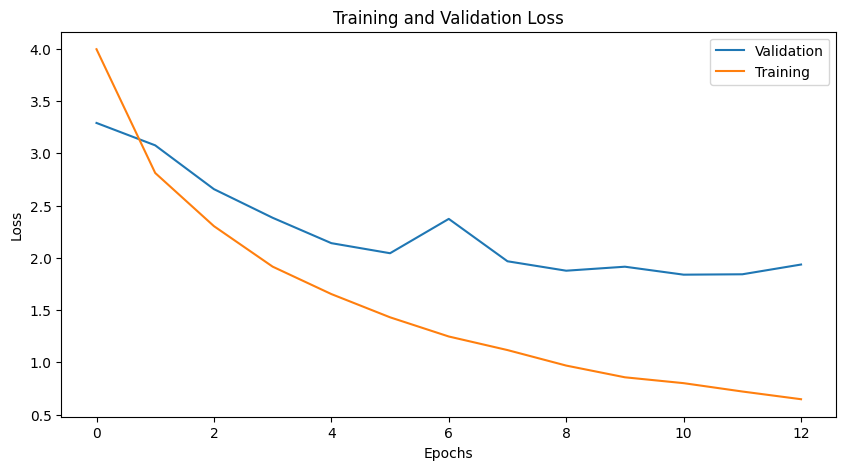

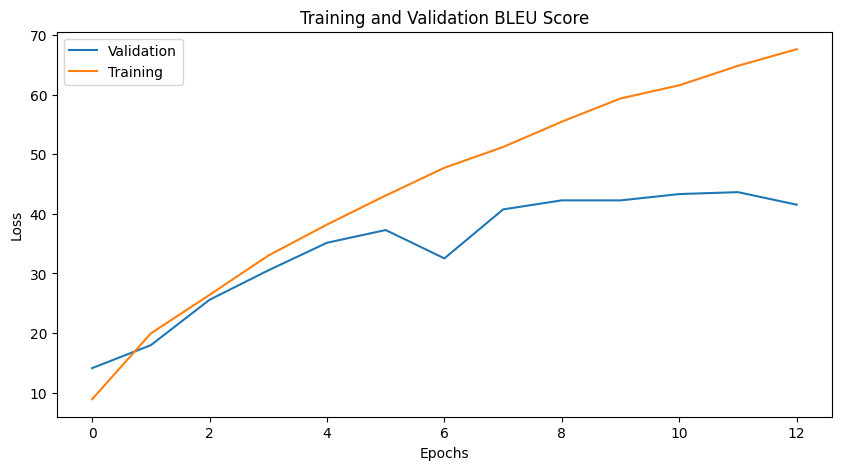

In [205]:
# Plot training and validation losses.
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses, label="Validation")
plt.plot(train_losses, label="Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot training and validation Accuracies.
plt.figure(figsize=(10,5))
plt.title("Training and Validation BLEU Score")
plt.plot(val_bleu, label="Validation")
plt.plot(train_bleu, label="Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

##Testing the Model

In [206]:
# Loading the Best Checkpoint
checkpoint = torch.load(bestcheckpoint_path, map_location=torch.device(device))

# Loading the state of model
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [207]:
loss, bleu, targets, pred =  train_or_val(model, optimizer, test_iterator, False)

# Calulating n-gram Score:
oneGram = corpus_bleu(targets, pred, weights=(1,0,0,0))
twoGram = corpus_bleu(targets, pred, weights=(0,1,0,0))
threeGram = corpus_bleu(targets, pred, weights=(0,0,1,0))
fourGram = corpus_bleu(targets, pred, weights=(0,0,0,1))

# Printing Various Bleu Score
print(f"\nTest Loss: {loss:>0.3f}\n")
print(f"1-Gram Bleu Score: {oneGram * 100:>0.2f}%")
print(f"2-Gram Bleu Score: {oneGram * 100:>0.2f}%")
print(f"3-Gram Bleu Score: {oneGram * 100:>0.2f}%")
print(f"4-Gram Bleu Score: {oneGram * 100:>0.2f}%")
print(f"Cumulative BLEU Score: {bleu:>0.2f}%")

100%|██████████| 39/39 [00:01<00:00, 26.87it/s]



Test Loss: 1.796

1-Gram Bleu Score: 74.17%
2-Gram Bleu Score: 74.17%
3-Gram Bleu Score: 74.17%
4-Gram Bleu Score: 74.17%
Cumulative BLEU Score: 43.12%


##Inferencing

In [220]:
def Eng2Urdu(sentence):

  # First, Tokenizing the sentence:
  tok_sen = eng_tokenization(sentence)

  # Mapping it to its Numerical Representation using English Vocablary
  numerical_vector = [en_field.vocab.stoi[i] for i in tok_sen]

  # Converting it into a tensor
  tensor_sentence = torch.tensor(numerical_vector).to(device)

  # Passing it through Encoder
  hidden, cell = model.encoder(tensor_sentence)

  # Passing it through Decoder:
  urdu = []

  # First, pass the <sos> token to the decoder
  sos_token = ur_field.vocab.stoi["<sos>"]
  input = torch.tensor(sos_token).to(device)

  # Getting the <eos> token for stopping
  eos_token = ur_field.vocab.stoi["<eos>"]

  for i in range(0, 30):

    words, hidden, cell = model.decoder(input, hidden, cell)

    # Getting predicited word
    prediction = words.argmax(0)

    # Storing it in the list
    urdu.append(prediction)

    # If last word i.e., <eos> token gets printed, break the loop
    if prediction == eos_token:
      break

    # Passing the predicted word as next input
    input = prediction

  # Converting Numerical Representation to Urdu Words
  urdu_sentence = [ur_field.vocab.itos[i] for i in urdu]
  output_string = ' '.join(urdu_sentence[0:-1])

  print(output_string)

In [222]:
Eng2Urdu("zain is your nephew")
Eng2Urdu("did he touch you?")
Eng2Urdu("how are you")
Eng2Urdu("why would you say that?")
Eng2Urdu("what is your name?")
Eng2Urdu("what is my name?")

زین تمہارا ہے
اس نے آپ کو دیکھا
آپ آپ ہیں
آپ یہ کہتے نہیں ؟
آپ کا نام کیا ہے
میرا میرا نام ہے
